In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree

#from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.metrics import PredictionErrorDisplay

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import datetime
import seaborn as sns
sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.mosaicplot import mosaic
pd.set_option('display.max_columns', 70)

In [ ]:
sanya = pd.read_excel('merge_hex_and_data.xlsx')

In [ ]:
df_hex = pd.read_csv('spb_hex.csv', sep = ',', decimal = ',', index_col = 0)
df_tracks = pd.read_csv('tracks_v2.csv', sep = ';', decimal = ',', index_col = 0)

In [ ]:
df_hex.shape

In [ ]:
avaible_hexes = sanya['h3_9'].unique().tolist()
len(avaible_hexes)

In [ ]:
df_ml = df_hex[df_hex['h3_9'].isin(avaible_hexes)]

In [ ]:
df_ml.shape

In [ ]:
gender_columns = ['male', 'female']
df_ml['total_gender'] = df_ml[gender_columns].sum(axis=1)

## Define df for model

In [ ]:
bins = [0, 1, 5, 10, 50, float('inf')]
group_labels = ['0', '1-5', '6-10', '11-50', '50+']


df_ml['total_groups'] = pd.cut(df_ml['total_gender'], bins=bins, labels=group_labels, right=False)

# Creating a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='total_groups', data=df_ml, palette='viridis')
plt.title('Distribution of Total in Updated Groups')
plt.xlabel('Total Range')
plt.ylabel('Count')
plt.show()

In [ ]:
df_ml = df_ml[df_ml['total_gender'] >280]

In [ ]:
avaible_hexes = df_ml['h3_9'].unique().tolist()
len(avaible_hexes)

In [ ]:
df_tracks.shape

In [ ]:
df_tracks = df_tracks[df_tracks['h3_9'].isin(avaible_hexes)]

In [ ]:
df_tracks.shape

In [ ]:
sanya = sanya[sanya['h3_9'].isin(avaible_hexes)]

In [ ]:
sanya.shape

## Make 14 day df

In [ ]:
df_tracks.head(5)

In [ ]:
df_tracks['start_dttm'] = pd.to_datetime(df_tracks['start_dttm'], format='%d.%m.%Y %H:%M')
df_tracks['end_dttm'] = pd.to_datetime(df_tracks['end_dttm'], format='%d.%m.%Y %H:%M')

**correct invalid cases**

In [34]:
invalid_cases = df_tracks[df_tracks['end_dttm'] < df_tracks['start_dttm']]
invalid_cases.shape

(4798, 4)

In [35]:
invalid_cases.head()

,id,start_dttm,end_dttm,h3_9
452,6.528350e+11,2023-08-31 21:39:00,2023-03-01 00:00:00,891106a9dbbffff
639,7.902740e+11,2023-08-31 19:22:00,2023-03-01 08:51:00,8911061412fffff
742,9.448930e+11,2023-08-31 21:16:00,2023-03-01 01:16:00,89110604eb7ffff
1047,1.331440e+12,2023-08-31 20:47:00,2023-03-01 01:17:00,891106072abffff
1314,1.657860e+12,2023-08-31 23:52:00,2023-03-01 04:26:00,891106a9c97ffff


In [36]:
invalid_cases.loc[invalid_cases['start_dttm'].dt.date == pd.to_datetime('2023-08-31').date(), 'start_dttm'] = \
    invalid_cases['start_dttm'].mask(invalid_cases['start_dttm'].notnull(), '2023-02-28 ' + invalid_cases['start_dttm'].dt.time.astype(str))

In [37]:
invalid_cases.head()

,id,start_dttm,end_dttm,h3_9
452,6.528350e+11,2023-02-28 21:39:00,2023-03-01 00:00:00,891106a9dbbffff
639,7.902740e+11,2023-02-28 19:22:00,2023-03-01 08:51:00,8911061412fffff
742,9.448930e+11,2023-02-28 21:16:00,2023-03-01 01:16:00,89110604eb7ffff
1047,1.331440e+12,2023-02-28 20:47:00,2023-03-01 01:17:00,891106072abffff
1314,1.657860e+12,2023-02-28 23:52:00,2023-03-01 04:26:00,891106a9c97ffff


In [38]:
df_tracks.loc[df_tracks['start_dttm'].dt.date == pd.to_datetime('2023-08-31').date(), 'start_dttm'] = \
    df_tracks['start_dttm'].mask(df_tracks['start_dttm'].notnull(), '2023-02-28 ' + df_tracks['start_dttm'].dt.time.astype(str))

In [39]:
df_tracks.shape

(382539, 4)

**continue transformation**

In [40]:
df_tracks['start_date'] = df_tracks['start_dttm'].dt.strftime('%Y-%m-%d')

In [41]:
df_tracks.head(5)

,id,start_dttm,end_dttm,h3_9,start_date
33,9.363030e+11,2023-03-03 12:33:00,2023-03-03 13:43:00,891106a8157ffff,2023-03-03
66,1.434520e+12,2023-03-12 21:26:00,2023-03-13 18:07:00,89110604d2bffff,2023-03-12
67,1.434520e+12,2023-03-13 18:26:00,2023-03-13 20:52:00,89110604d2bffff,2023-03-13
68,1.434520e+12,2023-03-08 21:17:00,2023-03-09 20:36:00,89110604d2bffff,2023-03-08
69,1.434520e+12,2023-03-10 12:45:00,2023-03-10 21:21:00,89110604d2bffff,2023-03-10


In [42]:
df_tracks['start_date'].value_counts()

2023-03-06    26906
2023-03-05    26619
2023-03-14    26598
2023-03-07    26512
2023-03-13    26488
2023-03-11    26395
2023-03-04    26303
2023-03-12    26289
2023-03-01    25524
2023-03-08    25374
2023-03-03    24031
2023-03-10    23905
2023-03-09    23203
2023-03-02    22759
2023-03-15    20731
2023-02-28     4902
Name: start_date, dtype: int64

In [43]:
df_tracks.h3_9.nunique()

719

In [44]:
df_tracks[df_tracks['start_date'] == '2023-03-15'].h3_9.nunique()

718

In [45]:
df_tracks = df_tracks[df_tracks['start_date'] != '2023-02-28']

In [46]:
avaible_hexes = df_tracks[df_tracks['start_date'] == '2023-03-15']['h3_9'].unique().tolist()

In [47]:
df_tracks = df_tracks[df_tracks['h3_9'].isin(avaible_hexes)]
sanya = sanya[sanya['h3_9'].isin(avaible_hexes)]
df_hex = df_hex[df_hex['h3_9'].isin(avaible_hexes)]

## Finally generate features

In [48]:
df_tracks.head(5)

,id,start_dttm,end_dttm,h3_9,start_date
33,9.363030e+11,2023-03-03 12:33:00,2023-03-03 13:43:00,891106a8157ffff,2023-03-03
66,1.434520e+12,2023-03-12 21:26:00,2023-03-13 18:07:00,89110604d2bffff,2023-03-12
67,1.434520e+12,2023-03-13 18:26:00,2023-03-13 20:52:00,89110604d2bffff,2023-03-13
68,1.434520e+12,2023-03-08 21:17:00,2023-03-09 20:36:00,89110604d2bffff,2023-03-08
69,1.434520e+12,2023-03-10 12:45:00,2023-03-10 21:21:00,89110604d2bffff,2023-03-10


In [49]:
# Функция для времени дня
def get_day_time(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 10:
        return 'morning'
    elif 10 <= hour < 18:
        return 'day'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'

# Для категории дня
def get_week_category(date):
    day_type = date.weekday()
    if day_type < 5:
        return 'weekday'
    else:
        return 'weekend'
        return 'weekend'

In [50]:
df_tracks['start_date'] = pd.to_datetime(df_tracks['start_date'], utc=True)

In [51]:
df_tracks['start_day_time'] = df_tracks['start_dttm'].apply(get_day_time)

In [52]:
df_tracks['start_week_class'] = df_tracks['start_date'].apply(get_week_category)

In [53]:
df_tracks['week_day'] = df_tracks['start_dttm'].dt.day_name()

In [54]:
df_tracks['sec_diff'] = (df_tracks['end_dttm'] - df_tracks['start_dttm']).dt.total_seconds()
df_tracks['hour_diff'] = round(df_tracks['sec_diff'] / 3600, 2)

In [55]:
df_tracks.head(5)

,id,start_dttm,end_dttm,h3_9,start_date,start_day_time,start_week_class,week_day,sec_diff,hour_diff
33,9.363030e+11,2023-03-03 12:33:00,2023-03-03 13:43:00,891106a8157ffff,2023-03-03 00:00:00+00:00,day,weekday,Friday,4200.0,1.17
66,1.434520e+12,2023-03-12 21:26:00,2023-03-13 18:07:00,89110604d2bffff,2023-03-12 00:00:00+00:00,evening,weekend,Sunday,74460.0,20.68
67,1.434520e+12,2023-03-13 18:26:00,2023-03-13 20:52:00,89110604d2bffff,2023-03-13 00:00:00+00:00,evening,weekday,Monday,8760.0,2.43
68,1.434520e+12,2023-03-08 21:17:00,2023-03-09 20:36:00,89110604d2bffff,2023-03-08 00:00:00+00:00,evening,weekday,Wednesday,83940.0,23.32
69,1.434520e+12,2023-03-10 12:45:00,2023-03-10 21:21:00,89110604d2bffff,2023-03-10 00:00:00+00:00,day,weekday,Friday,30960.0,8.60


In [56]:
%%time
statistics_df = pd.DataFrame()

# Unique dates and h3_9 combinations
unique_combinations = df_tracks[['start_date', 'h3_9']].drop_duplicates()

for index, row in unique_combinations.iterrows():
    date_condition = (df_tracks['start_date'] == row['start_date'])
    h3_9_condition = (df_tracks['h3_9'] == row['h3_9'])
    filtered_data = df_tracks[date_condition & h3_9_condition]

    visit_count = filtered_data.shape[0]
    avg_duration = filtered_data['hour_diff'].mean()

    # Weekday and weekend visits
    weekday_visits = filtered_data[filtered_data['start_week_class'] == 'weekday'].shape[0]
    weekend_visits = filtered_data[filtered_data['start_week_class'] == 'weekend'].shape[0]

    # Visits on each day of the week
    day_visits = filtered_data.groupby('week_day').size()

    # Visits based on start_day_time
    time_visits = filtered_data.groupby('start_day_time').size()

    # статистика по duration
    stay_categories = ['Stay0_05h', 'Stay05_1h', 'Stay1_3h', 'Stay3_6h', 'Stay6_9h', 'Stay9_15h', 'Stay15_20h', 'Stay20_plus']
    duration_bins = [0, 0.5, 1, 3, 6, 9, 15, 20, float('inf')]
    duration_counts = pd.cut(filtered_data['hour_diff'], bins=duration_bins, labels=stay_categories).value_counts()

    stats_dict = {
        'start_date': row['start_date'],
        'h3_9': row['h3_9'],
        'visit_count': visit_count,
        'avg_duration': avg_duration,
        'weekday_visits': weekday_visits,
        'weekend_visits': weekend_visits,
        **day_visits.to_dict(),
        **time_visits.to_dict(),
        **duration_counts.to_dict(),
        'morning_visits': time_visits.get('morning', 0),
        'day_visits': time_visits.get('day', 0),
        'evening_visits': time_visits.get('evening', 0),
        'night_visits': time_visits.get('night', 0),
    }

    statistics_df = statistics_df.append(stats_dict, ignore_index=True)

day_columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
statistics_df[day_columns] = statistics_df[day_columns].fillna(0)

CPU times: total: 4min 46s
Wall time: 6min 27s


In [57]:
statistics_df.shape

(10770, 29)

In [58]:
statistics_df.columns

Index(['start_date', 'h3_9', 'visit_count', 'avg_duration', 'weekday_visits',
       'weekend_visits', 'Friday', 'day', 'evening', 'morning', 'night',
       'Stay1_3h', 'Stay05_1h', 'Stay3_6h', 'Stay6_9h', 'Stay9_15h',
       'Stay0_05h', 'Stay15_20h', 'Stay20_plus', 'morning_visits',
       'day_visits', 'evening_visits', 'night_visits', 'Sunday', 'Monday',
       'Wednesday', 'Thursday', 'Tuesday', 'Saturday'],
      dtype='object')

In [59]:
statistics_df.head(10)

,start_date,h3_9,visit_count,avg_duration,weekday_visits,weekend_visits,Friday,day,evening,morning,night,Stay1_3h,Stay05_1h,Stay3_6h,Stay6_9h,Stay9_15h,Stay0_05h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Sunday,Monday,Wednesday,Thursday,Tuesday,Saturday
0,2023-03-03 00:00:00+00:00,891106a8157ffff,49,2.782857,49,0,49.0,14.0,9.0,5.0,21.0,26,9,9,4,1,0,0,0,5,14,9,21,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-03-12 00:00:00+00:00,89110604d2bffff,39,6.445641,0,39,0.0,14.0,9.0,3.0,13.0,15,1,7,7,5,0,1,3,3,14,9,13,39.0,0.0,0.0,0.0,0.0,0.0
2,2023-03-13 00:00:00+00:00,89110604d2bffff,41,6.086585,41,0,0.0,13.0,6.0,5.0,17.0,14,5,11,4,1,0,3,3,5,13,6,17,0.0,41.0,0.0,0.0,0.0,0.0
3,2023-03-08 00:00:00+00:00,89110604d2bffff,34,4.910882,34,0,0.0,16.0,8.0,2.0,8.0,17,5,4,3,2,0,0,3,2,16,8,8,0.0,0.0,34.0,0.0,0.0,0.0
4,2023-03-10 00:00:00+00:00,89110604d2bffff,31,5.800645,31,0,31.0,12.0,6.0,3.0,10.0,13,1,7,5,2,0,1,2,3,12,6,10,0.0,0.0,0.0,0.0,0.0,0.0
5,2023-03-09 00:00:00+00:00,89110604d2bffff,37,6.890541,37,0,0.0,13.0,11.0,3.0,10.0,16,2,7,2,2,0,5,3,3,13,11,10,0.0,0.0,0.0,37.0,0.0,0.0
6,2023-03-05 00:00:00+00:00,89110604d2bffff,37,6.155676,0,37,0.0,10.0,11.0,3.0,13.0,17,2,5,7,2,0,1,3,3,10,11,13,37.0,0.0,0.0,0.0,0.0,0.0
7,2023-03-07 00:00:00+00:00,89110604d2bffff,47,5.209149,47,0,0.0,18.0,10.0,6.0,13.0,23,3,8,5,4,0,2,2,6,18,10,13,0.0,0.0,0.0,0.0,47.0,0.0
8,2023-03-14 00:00:00+00:00,89110604d2bffff,35,6.622000,35,0,0.0,11.0,9.0,4.0,11.0,9,2,10,7,3,0,2,2,4,11,9,11,0.0,0.0,0.0,0.0,35.0,0.0
9,2023-03-01 00:00:00+00:00,89110604d2bffff,20,6.239500,20,0,0.0,10.0,3.0,1.0,6.0,8,0,4,4,2,0,1,1,1,10,3,6,0.0,0.0,20.0,0.0,0.0,0.0


## Переделываем дни и будни в бинарные колонки. Так делаем для модели по дням

In [60]:
statistics_df.head(5)

,start_date,h3_9,visit_count,avg_duration,weekday_visits,weekend_visits,Friday,day,evening,morning,night,Stay1_3h,Stay05_1h,Stay3_6h,Stay6_9h,Stay9_15h,Stay0_05h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Sunday,Monday,Wednesday,Thursday,Tuesday,Saturday
0,2023-03-03 00:00:00+00:00,891106a8157ffff,49,2.782857,49,0,49.0,14.0,9.0,5.0,21.0,26,9,9,4,1,0,0,0,5,14,9,21,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-03-12 00:00:00+00:00,89110604d2bffff,39,6.445641,0,39,0.0,14.0,9.0,3.0,13.0,15,1,7,7,5,0,1,3,3,14,9,13,39.0,0.0,0.0,0.0,0.0,0.0
2,2023-03-13 00:00:00+00:00,89110604d2bffff,41,6.086585,41,0,0.0,13.0,6.0,5.0,17.0,14,5,11,4,1,0,3,3,5,13,6,17,0.0,41.0,0.0,0.0,0.0,0.0
3,2023-03-08 00:00:00+00:00,89110604d2bffff,34,4.910882,34,0,0.0,16.0,8.0,2.0,8.0,17,5,4,3,2,0,0,3,2,16,8,8,0.0,0.0,34.0,0.0,0.0,0.0
4,2023-03-10 00:00:00+00:00,89110604d2bffff,31,5.800645,31,0,31.0,12.0,6.0,3.0,10.0,13,1,7,5,2,0,1,2,3,12,6,10,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
statistics_df = statistics_df.drop(['night', 'day', 'evening', 'morning'], axis=1)

In [62]:
df_model = statistics_df.copy()

In [63]:
columns_to_update = ['weekday_visits', 'weekend_visits',
                    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_model[columns_to_update] = df_model[columns_to_update].applymap(lambda x: 1 if x > 0 else x)

In [64]:
df_model = df_model.rename(columns={'weekday_visits': 'weekday', 'weekend_visits': 'weekend'})

In [65]:
df_model.columns

Index(['start_date', 'h3_9', 'visit_count', 'avg_duration', 'weekday',
       'weekend', 'Friday', 'Stay1_3h', 'Stay05_1h', 'Stay3_6h', 'Stay6_9h',
       'Stay9_15h', 'Stay0_05h', 'Stay15_20h', 'Stay20_plus', 'morning_visits',
       'day_visits', 'evening_visits', 'night_visits', 'Sunday', 'Monday',
       'Wednesday', 'Thursday', 'Tuesday', 'Saturday'],
      dtype='object')

In [66]:
desired_column_order = ['start_date', 'h3_9', 'visit_count', 'avg_duration', 'Stay0_05h', 'Stay05_1h', 'Stay1_3h', 'Stay3_6h',
                         'Stay6_9h', 'Stay9_15h', 'Stay15_20h', 'Stay20_plus', 'morning_visits', 'day_visits', 'evening_visits', 'night_visits',
                         'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'weekday', 'weekend']

df_model = df_model[desired_column_order]

In [67]:
df_model.head(5)

,start_date,h3_9,visit_count,avg_duration,Stay0_05h,Stay05_1h,Stay1_3h,Stay3_6h,Stay6_9h,Stay9_15h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend
0,2023-03-03 00:00:00+00:00,891106a8157ffff,49,2.782857,0,9,26,9,4,1,0,0,5,14,9,21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
1,2023-03-12 00:00:00+00:00,89110604d2bffff,39,6.445641,0,1,15,7,7,5,1,3,3,14,9,13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
2,2023-03-13 00:00:00+00:00,89110604d2bffff,41,6.086585,0,5,14,11,4,1,3,3,5,13,6,17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,2023-03-08 00:00:00+00:00,89110604d2bffff,34,4.910882,0,5,17,4,3,2,0,3,2,16,8,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
4,2023-03-10 00:00:00+00:00,89110604d2bffff,31,5.800645,0,1,13,7,5,2,1,2,3,12,6,10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0


## Join OMS data

In [68]:
sanya.head(5)

,geometry,polylines,id,city,object,type,index_right,lat,lon,h3_9
43,"POLYGON ((30.29765402858296 60.00992613191663,...","[(60.00992613191663, 30.29765402858296), (60.0...",36,Санкт-Петербург,amenity,cafe,1603,60.008176,30.297619,891106a959bffff
44,"POLYGON ((30.29765402858296 60.00992613191663,...","[(60.00992613191663, 30.29765402858296), (60.0...",36,Санкт-Петербург,amenity,restaurant,1603,60.008176,30.297619,891106a959bffff
45,"POLYGON ((30.29765402858296 60.00992613191663,...","[(60.00992613191663, 30.29765402858296), (60.0...",36,Санкт-Петербург,amenity,fast_food,1603,60.008176,30.297619,891106a959bffff
46,"POLYGON ((30.29765402858296 60.00992613191663,...","[(60.00992613191663, 30.29765402858296), (60.0...",36,Санкт-Петербург,amenity,fast_food,1603,60.008176,30.297619,891106a959bffff
47,"POLYGON ((30.29765402858296 60.00992613191663,...","[(60.00992613191663, 30.29765402858296), (60.0...",36,Санкт-Петербург,amenity,fast_food,1603,60.008176,30.297619,891106a959bffff


In [69]:
objects = sanya['object'].unique().tolist()
objects

['amenity', 'building', 'footway', 'highway']

In [70]:
sanya.type.value_counts(normalize = True)

types = sanya['type'].unique().tolist()
types

['cafe',
 'restaurant',
 'fast_food',
 'retail',
 'crossing',
 'hospital',
 'pharmacy',
 'bank',
 'apartments',
 'bus_stop',
 'university',
 'dormitory',
 'bench',
 'school',
 'atm',
 'theatre',
 'language_school',
 'commercial',
 'office',
 'clinic',
 'train_station',
 'house',
 'townhall',
 'hotel',
 'college',
 'terrace',
 'detached']

In [71]:
df_oms = sanya[['h3_9', 'object', 'type']]

In [72]:
df_oms.head(10)

,h3_9,object,type
43,891106a959bffff,amenity,cafe
44,891106a959bffff,amenity,restaurant
45,891106a959bffff,amenity,fast_food
46,891106a959bffff,amenity,fast_food
47,891106a959bffff,amenity,fast_food
48,891106a959bffff,amenity,fast_food
49,891106a959bffff,building,retail
50,891106a959bffff,amenity,restaurant
51,891106a959bffff,footway,crossing
52,891106a959bffff,amenity,hospital


In [73]:
df_model_save = df_model.copy()

In [74]:
df_model

,start_date,h3_9,visit_count,avg_duration,Stay0_05h,Stay05_1h,Stay1_3h,Stay3_6h,Stay6_9h,Stay9_15h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend
0,2023-03-03 00:00:00+00:00,891106a8157ffff,49,2.782857,0,9,26,9,4,1,0,0,5,14,9,21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
1,2023-03-12 00:00:00+00:00,89110604d2bffff,39,6.445641,0,1,15,7,7,5,1,3,3,14,9,13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
2,2023-03-13 00:00:00+00:00,89110604d2bffff,41,6.086585,0,5,14,11,4,1,3,3,5,13,6,17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,2023-03-08 00:00:00+00:00,89110604d2bffff,34,4.910882,0,5,17,4,3,2,0,3,2,16,8,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
4,2023-03-10 00:00:00+00:00,89110604d2bffff,31,5.800645,0,1,13,7,5,2,1,2,3,12,6,10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765,2023-03-03 00:00:00+00:00,891106074b7ffff,1,1.500000,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
10766,2023-03-10 00:00:00+00:00,891106a9e0bffff,13,4.272308,0,1,6,3,1,1,1,0,1,3,5,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
10767,2023-03-09 00:00:00+00:00,891106046c3ffff,16,7.380625,0,4,5,1,2,2,0,2,3,3,1,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
10768,2023-03-12 00:00:00+00:00,891106046c3ffff,12,4.529167,0,1,6,3,1,0,0,1,3,3,3,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1


## New table with aggregation

In [75]:
%%time
unique_objects = df_oms['object'].unique()
unique_types = df_oms['type'].unique()

new_df = pd.DataFrame(index=df_oms['h3_9'].unique())

for obj in unique_objects:
    new_df[f'{obj}_count'] = df_oms[df_oms['object'] == obj].groupby('h3_9')['object'].count()

for t in unique_types:
    new_df[f'{t}_count'] = df_oms[df_oms['type'] == t].groupby('h3_9')['type'].count()

new_df = new_df.fillna(0).astype(int)

CPU times: total: 0 ns
Wall time: 76.2 ms


In [76]:
df_oms[df_oms['h3_9'] == '8911060609bffff'].shape

(76, 3)

In [77]:
new_df.insert(0, 'h3_9', new_df.index)
new_df = new_df.reset_index(drop=True)

In [78]:
new_df

,h3_9,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,hospital_count,pharmacy_count,bank_count,apartments_count,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,office_count,clinic_count,train_station_count,house_count,townhall_count,hotel_count,college_count,terrace_count,detached_count
0,891106a959bffff,11,3,3,1,1,2,5,1,3,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,89110606c13ffff,2,3,2,1,1,0,0,0,2,0,0,0,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,891106a94c7ffff,11,11,12,0,0,2,0,1,12,0,0,0,10,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8911060551bffff,1,1,2,1,0,0,0,0,2,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8911060609bffff,60,6,5,5,16,14,6,1,5,0,2,0,2,5,0,0,3,0,12,4,3,2,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,89110604c13ffff,1,4,2,1,0,0,0,0,2,0,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
714,891106153d7ffff,2,3,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
715,891106ab0abffff,9,3,0,0,0,0,0,0,0,0,0,0,3,0,0,0,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0
716,891106a9a9bffff,12,10,2,2,2,0,0,0,2,0,5,1,10,2,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
df_model_save = df_model.copy()

In [80]:
df_model = df_model.merge(new_df, on='h3_9', how='left')

In [81]:
df_model = df_model.sort_values(by=['h3_9', 'start_date'], ascending=True).reset_index(drop=True)

In [82]:
df_model

,start_date,h3_9,visit_count,avg_duration,Stay0_05h,Stay05_1h,Stay1_3h,Stay3_6h,Stay6_9h,Stay9_15h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,hospital_count,pharmacy_count,bank_count,apartments_count,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,office_count,clinic_count,train_station_count,house_count,townhall_count,hotel_count,college_count,terrace_count,detached_count
0,2023-03-01 00:00:00+00:00,891106004b7ffff,36,2.592222,0,0,29,5,1,0,1,0,5,16,5,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2023-03-02 00:00:00+00:00,891106004b7ffff,29,2.258276,0,1,20,8,0,0,0,0,8,9,2,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2023-03-03 00:00:00+00:00,891106004b7ffff,26,2.075385,0,0,22,4,0,0,0,0,8,8,3,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2023-03-04 00:00:00+00:00,891106004b7ffff,27,2.572593,0,2,18,5,1,1,0,0,6,9,6,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2023-03-05 00:00:00+00:00,891106004b7ffff,39,2.106410,0,3,28,7,1,0,0,0,8,10,7,14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765,2023-03-11 00:00:00+00:00,891106b98bbffff,70,3.782714,0,7,41,8,5,7,1,1,3,22,22,23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10766,2023-03-12 00:00:00+00:00,891106b98bbffff,70,3.822429,0,11,36,10,4,6,1,2,3,19,23,25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10767,2023-03-13 00:00:00+00:00,891106b98bbffff,69,3.442174,0,10,31,18,4,5,1,0,3,13,25,28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10768,2023-03-14 00:00:00+00:00,891106b98bbffff,68,3.981029,0,2,35,18,8,4,0,1,3,20,15,30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Join features from df_hex

In [83]:
df_hex.head()

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5
11,89110602883ffff,0,55,53,112,41,157,127,61,14,152,1,1,56,54,22,61,35
38,891106159b3ffff,0,18,35,184,114,193,199,122,60,129,1,11,126,126,9,44,10
83,891106141abffff,0,21,98,110,45,150,163,111,34,132,18,0,80,30,66,1,4
109,891106ab077ffff,0,8,324,143,25,268,243,161,61,173,0,0,221,29,113,59,36
117,891106a9e7bffff,1,61,115,128,47,256,135,130,82,232,34,1,175,69,27,58,6


In [84]:
gender_columns = ['male', 'female']

df_hex['total_gender'] = df_hex[gender_columns].sum(axis=1)

In [85]:
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

for age_col in age_columns:
    share_col = age_col + '_share'
    df_hex[share_col] = df_hex[age_col] / df_hex[age_columns].sum(axis=1)

In [86]:
gender_columns = ['male', 'female']

for g_col in gender_columns:
    share_col = g_col + '_share'
    df_hex[share_col] = df_hex[g_col] / df_hex[gender_columns].sum(axis=1)

In [87]:
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

for s_col in salary_columns:
    share_col = s_col + '_share'
    df_hex[share_col] = df_hex[s_col] / df_hex[salary_columns].sum(axis=1)

In [88]:
other_columns = ['car_owners', 'public_trnsprt_user', 'healthy_food_inter', ]

for o_col in other_columns:
    share_col = o_col + '_share'
    df_hex[share_col] = df_hex[o_col] / df_hex['total_gender']

In [89]:
car_columns = ['not_citizen_rf', 'carsharing_user']

for c_col in car_columns:
    share_col = c_col + '_share'
    df_hex[share_col] = df_hex[c_col] / df_hex['total_gender']

In [90]:
columns_to_drop = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60', 
                   'male', 'female', 'car_owners', 'carsharing_user', 
                   'not_citizen_rf', 'public_trnsprt_user', 'healthy_food_inter', 
                   'salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

df_hex_perc_only = df_hex.drop(columns=columns_to_drop)

In [91]:
df_hex_perc_only

,h3_9,total_gender,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,public_trnsprt_user_share,healthy_food_inter_share,not_citizen_rf_share,carsharing_user_share
11,89110602883ffff,284,0.000000,0.210728,0.203065,0.429119,0.157088,0.552817,0.447183,0.245614,0.236842,0.096491,0.267544,0.153509,0.214789,0.003521,0.003521,0.535211,0.049296
38,891106159b3ffff,392,0.000000,0.051282,0.099715,0.524217,0.324786,0.492347,0.507653,0.400000,0.400000,0.028571,0.139683,0.031746,0.311224,0.002551,0.028061,0.329082,0.153061
83,891106141abffff,313,0.000000,0.076642,0.357664,0.401460,0.164234,0.479233,0.520767,0.441989,0.165746,0.364641,0.005525,0.022099,0.354633,0.057508,0.000000,0.421725,0.108626
109,891106ab077ffff,511,0.000000,0.016000,0.648000,0.286000,0.050000,0.524462,0.475538,0.482533,0.063319,0.246725,0.128821,0.078603,0.315068,0.000000,0.000000,0.338552,0.119374
117,891106a9e7bffff,391,0.002841,0.173295,0.326705,0.363636,0.133523,0.654731,0.345269,0.522388,0.205970,0.080597,0.173134,0.017910,0.332481,0.086957,0.002558,0.593350,0.209719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27505,8911060402bffff,1070,0.041298,0.249754,0.141593,0.545723,0.021632,0.591589,0.408411,0.269663,0.363636,0.213483,0.134831,0.018386,0.322430,0.000935,0.020561,0.557944,0.049533
27618,8911060510bffff,494,0.000000,0.160521,0.277657,0.542299,0.019523,0.572874,0.427126,0.320707,0.161616,0.275253,0.189394,0.053030,0.257085,0.000000,0.000000,0.655870,0.364372
27684,891106ab307ffff,1430,0.000000,0.088635,0.419585,0.364546,0.127234,0.477622,0.522378,0.494333,0.143854,0.231037,0.112467,0.018309,0.393706,0.021678,0.068531,0.437063,0.200000
27694,891106109c7ffff,615,0.003559,0.190391,0.225979,0.418149,0.161922,0.647154,0.352846,0.407025,0.342975,0.059917,0.006198,0.183884,0.551220,0.123577,0.000000,0.440650,0.183740


In [92]:
df_model = df_model.merge(df_hex_perc_only, on='h3_9', how='left')

In [93]:
columns = df_model.columns.tolist()

columns.insert(3, columns.pop(columns.index('total_gender')))
df_model = df_model[columns]

In [94]:
df_model

,start_date,h3_9,visit_count,total_gender,avg_duration,Stay0_05h,Stay05_1h,Stay1_3h,Stay3_6h,Stay6_9h,Stay9_15h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,...,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,office_count,clinic_count,train_station_count,house_count,townhall_count,hotel_count,college_count,terrace_count,detached_count,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,public_trnsprt_user_share,healthy_food_inter_share,not_citizen_rf_share,carsharing_user_share
0,2023-03-01 00:00:00+00:00,891106004b7ffff,36,484,2.592222,0,0,29,5,1,0,1,0,5,16,5,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
1,2023-03-02 00:00:00+00:00,891106004b7ffff,29,484,2.258276,0,1,20,8,0,0,0,0,8,9,2,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
2,2023-03-03 00:00:00+00:00,891106004b7ffff,26,484,2.075385,0,0,22,4,0,0,0,0,8,8,3,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
3,2023-03-04 00:00:00+00:00,891106004b7ffff,27,484,2.572593,0,2,18,5,1,1,0,0,6,9,6,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
4,2023-03-05 00:00:00+00:00,891106004b7ffff,39,484,2.106410,0,3,28,7,1,0,0,0,8,10,7,14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765,2023-03-11 00:00:00+00:00,891106b98bbffff,70,1080,3.782714,0,7,41,8,5,7,1,1,3,22,22,23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.072091,0.039135,0.347065,0.346035,0.195675,0.593519,0.406481,0.594779,0.209989,0.081725,0.063564,0.049943,0.455556,0.048148,0.000000,0.460185,0.076852
10766,2023-03-12 00:00:00+00:00,891106b98bbffff,70,1080,3.822429,0,11,36,10,4,6,1,2,3,19,23,25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.072091,0.039135,0.347065,0.346035,0.195675,0.593519,0.406481,0.594779,0.209989,0.081725,0.063564,0.049943,0.455556,0.048148,0.000000,0.460185,0.076852
10767,2023-03-13 00:00:00+00:00,891106b98bbffff,69,1080,3.442174,0,10,31,18,4,5,1,0,3,13,25,28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.072091,0.039135,0.347065,0.346035,0.195675,0.593519,0.406481,0.594779,0.209989,0.081725,0.063564,0.049943,0.455556,0.048148,0.000000,0.460185,0.076852
10768,2023-03-14 00:00:00+00:00,891106b98bbffff,68,1080,3.981029,0,2,35,18,8,4,0,1,3,20,15,30,0.0,1.0,0.0,0

In [95]:
df_model.h3_9.nunique()

718

In [138]:
718*15

10770

In [96]:
df_model.to_csv('dataset_for_modeling.csv', index=False)

## Этап моделирования

In [2]:
df_model = pd.read_csv('dataset_for_modeling.csv')

In [3]:
df_model

,start_date,h3_9,visit_count,total_gender,avg_duration,Stay0_05h,Stay05_1h,Stay1_3h,Stay3_6h,Stay6_9h,Stay9_15h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,...,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,office_count,clinic_count,train_station_count,house_count,townhall_count,hotel_count,college_count,terrace_count,detached_count,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,public_trnsprt_user_share,healthy_food_inter_share,not_citizen_rf_share,carsharing_user_share
0,2023-03-01 00:00:00+00:00,891106004b7ffff,36,484,2.592222,0,0,29,5,1,0,1,0,5,16,5,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
1,2023-03-02 00:00:00+00:00,891106004b7ffff,29,484,2.258276,0,1,20,8,0,0,0,0,8,9,2,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
2,2023-03-03 00:00:00+00:00,891106004b7ffff,26,484,2.075385,0,0,22,4,0,0,0,0,8,8,3,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
3,2023-03-04 00:00:00+00:00,891106004b7ffff,27,484,2.572593,0,2,18,5,1,1,0,0,6,9,6,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
4,2023-03-05 00:00:00+00:00,891106004b7ffff,39,484,2.106410,0,3,28,7,1,0,0,0,8,10,7,14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.057395,0.392936,0.377483,0.172185,0.526860,0.473140,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765,2023-03-11 00:00:00+00:00,891106b98bbffff,70,1080,3.782714,0,7,41,8,5,7,1,1,3,22,22,23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.072091,0.039135,0.347065,0.346035,0.195675,0.593519,0.406481,0.594779,0.209989,0.081725,0.063564,0.049943,0.455556,0.048148,0.000000,0.460185,0.076852
10766,2023-03-12 00:00:00+00:00,891106b98bbffff,70,1080,3.822429,0,11,36,10,4,6,1,2,3,19,23,25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.072091,0.039135,0.347065,0.346035,0.195675,0.593519,0.406481,0.594779,0.209989,0.081725,0.063564,0.049943,0.455556,0.048148,0.000000,0.460185,0.076852
10767,2023-03-13 00:00:00+00:00,891106b98bbffff,69,1080,3.442174,0,10,31,18,4,5,1,0,3,13,25,28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.072091,0.039135,0.347065,0.346035,0.195675,0.593519,0.406481,0.594779,0.209989,0.081725,0.063564,0.049943,0.455556,0.048148,0.000000,0.460185,0.076852
10768,2023-03-14 00:00:00+00:00,891106b98bbffff,68,1080,3.981029,0,2,35,18,8,4,0,1,3,20,15,30,0.0,1.0,0.0,0

## Model

## Проверяем есть ли колонки с очень большой долей нулей

In [4]:
zero_share = (df_model == 0).mean()
zero_share_table = pd.DataFrame({'Column': zero_share.index, 'Zero Share': zero_share.values})

columns_with_high_zero_share = zero_share_table[zero_share_table['Zero Share'] > 0.8]['Column'].tolist()
pd.set_option('display.max_rows', None)
zero_share_table

,Column,Zero Share
0,start_date,0.000000
1,h3_9,0.000000
2,visit_count,0.000000
3,total_gender,0.000000
4,avg_duration,0.000000
5,Stay0_05h,1.000000
6,Stay05_1h,0.132591
7,Stay1_3h,0.000093
8,Stay3_6h,0.017456
9,Stay6_9h,0.105664


In [5]:
pd.set_option('display.max_rows', 20)

## SMA baseline

**Делаем предсказание на основе среднего за несколько предшествующих периодов, берем среднюю величину метрик для всех гексов**

In [6]:
df_model.head(3)

,start_date,h3_9,visit_count,total_gender,avg_duration,Stay0_05h,Stay05_1h,Stay1_3h,Stay3_6h,Stay6_9h,Stay9_15h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,...,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,office_count,clinic_count,train_station_count,house_count,townhall_count,hotel_count,college_count,terrace_count,detached_count,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,public_trnsprt_user_share,healthy_food_inter_share,not_citizen_rf_share,carsharing_user_share
0,2023-03-01 00:00:00+00:00,891106004b7ffff,36,484,2.592222,0,0,29,5,1,0,1,0,5,16,5,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.057395,0.392936,0.377483,0.172185,0.52686,0.47314,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
1,2023-03-02 00:00:00+00:00,891106004b7ffff,29,484,2.258276,0,1,20,8,0,0,0,0,8,9,2,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.057395,0.392936,0.377483,0.172185,0.52686,0.47314,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
2,2023-03-03 00:00:00+00:00,891106004b7ffff,26,484,2.075385,0,0,22,4,0,0,0,0,8,8,3,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.057395,0.392936,0.377483,0.172185,0.52686,0.47314,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413


In [7]:
df_sma = df_model[['start_date', 'h3_9', 'visit_count']]

In [8]:
df_sma = df_sma.sort_values(['h3_9', 'start_date'])

In [9]:
df_sma

,start_date,h3_9,visit_count
0,2023-03-01 00:00:00+00:00,891106004b7ffff,36
1,2023-03-02 00:00:00+00:00,891106004b7ffff,29
2,2023-03-03 00:00:00+00:00,891106004b7ffff,26
3,2023-03-04 00:00:00+00:00,891106004b7ffff,27
4,2023-03-05 00:00:00+00:00,891106004b7ffff,39
...,...,...,...
10765,2023-03-11 00:00:00+00:00,891106b98bbffff,70
10766,2023-03-12 00:00:00+00:00,891106b98bbffff,70
10767,2023-03-13 00:00:00+00:00,891106b98bbffff,69
10768,2023-03-14 00:00:00+00:00,891106b98bbffff,68


## SMA for average periods

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

df_sma['start_date'] = pd.to_datetime(df_sma['start_date'])


def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(df, window_sizes):
    results = []
    for window_size in window_sizes:
        #SMA
        df[f'SMA_{window_size}'] = df['visit_count'].shift(-window_size).rolling(window=window_size).mean()
        
        df_model = df.dropna(subset=[f'SMA_{window_size}'])
        
        if not df_model.empty:
            # Calculate metrics
            mse = mean_squared_error(df_model['visit_count'], df_model[f'SMA_{window_size}'])
            mae = mean_absolute_error(df_model['visit_count'], df_model[f'SMA_{window_size}'])
            mape = calculate_mape(df_model['visit_count'], df_model[f'SMA_{window_size}'])
            
            results.append({
                'Period avg': window_size,
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape
            })
    
    return results

window_sizes = [1, 3, 5, 7]
all_h3_9_results = []

for unique_h3_9 in df_sma['h3_9'].unique():
    df_subset = df_sma[df_sma['h3_9'] == unique_h3_9].copy()  # Copy to avoid modifying
    results_for_h3_9 = calculate_metrics(df_subset, window_sizes)
    all_h3_9_results.extend(results_for_h3_9)
    
results_all_hex = pd.DataFrame(all_h3_9_results)
results_avg = results_all_hex.groupby('Period avg').mean()

In [11]:
results_all_hex

,Period avg,MSE,MAE,MAPE
0,1,68.428571,6.857143,22.561027
1,3,38.633333,5.233333,17.262677
2,5,45.880000,5.066667,16.177089
3,7,3.602041,1.785714,5.821813
4,1,62.571429,6.428571,35.642195
...,...,...,...,...
2867,7,10.204082,2.857143,14.679556
2868,1,125.285714,8.714286,13.795729
2869,3,52.166667,6.166667,9.165957
2870,5,86.273333,8.033333,12.188917


In [12]:
results_avg

,MSE,MAE,MAPE
Period avg,,,
1,82.454536,7.010247,23.459984
3,63.967332,6.177484,21.747404
5,61.750074,6.068942,21.118185
7,48.669533,5.349881,16.977499


## Берем значение ровно неделю назад и подставляем

In [13]:
df_sma['start_date'] = pd.to_datetime(df_sma['start_date'])

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def create_model(df):
    df['Future'] = df['visit_count'].shift(-6)
    df_model = df.dropna(subset=['Future'])
    
    mse = mean_squared_error(df_model['visit_count'], df_model['Future'])
    mae = mean_absolute_error(df_model['visit_count'], df_model['Future'])
    mape = calculate_mape(df_model['visit_count'], df_model['Future'])
    
    return {
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    }

all_results = []

for unique_h3_9 in df_sma['h3_9'].unique():
    df_subset = df_sma[df_sma['h3_9'] == unique_h3_9].copy()
    results_for_h3_9 = create_model(df_subset)
    
    all_results.append(results_for_h3_9)

results_df_model = pd.DataFrame(all_results)

average_metrics_model_week_ago = results_df_model.mean()
average_metrics_model_week_ago = pd.DataFrame(average_metrics_model_week_ago)

In [14]:
results_df_model

,MSE,MAE,MAPE
0,53.888889,6.555556,20.971121
1,56.444444,6.222222,31.771267
2,33.222222,5.222222,22.327765
3,65.222222,6.555556,22.858309
4,55.333333,6.888889,10.853340
...,...,...,...
713,23.888889,4.111111,9.970591
714,63.777778,6.444444,17.110782
715,75.888889,6.777778,27.974491
716,30.111111,4.777778,26.734013


In [15]:
average_metrics_model_week_ago

,0
MSE,93.297741
MAE,7.421541
MAPE,25.062418


## SMA for one case for plot

In [16]:
hex_1 = df_model[(df_model.h3_9 == '891106004b7ffff')].set_index('start_date')

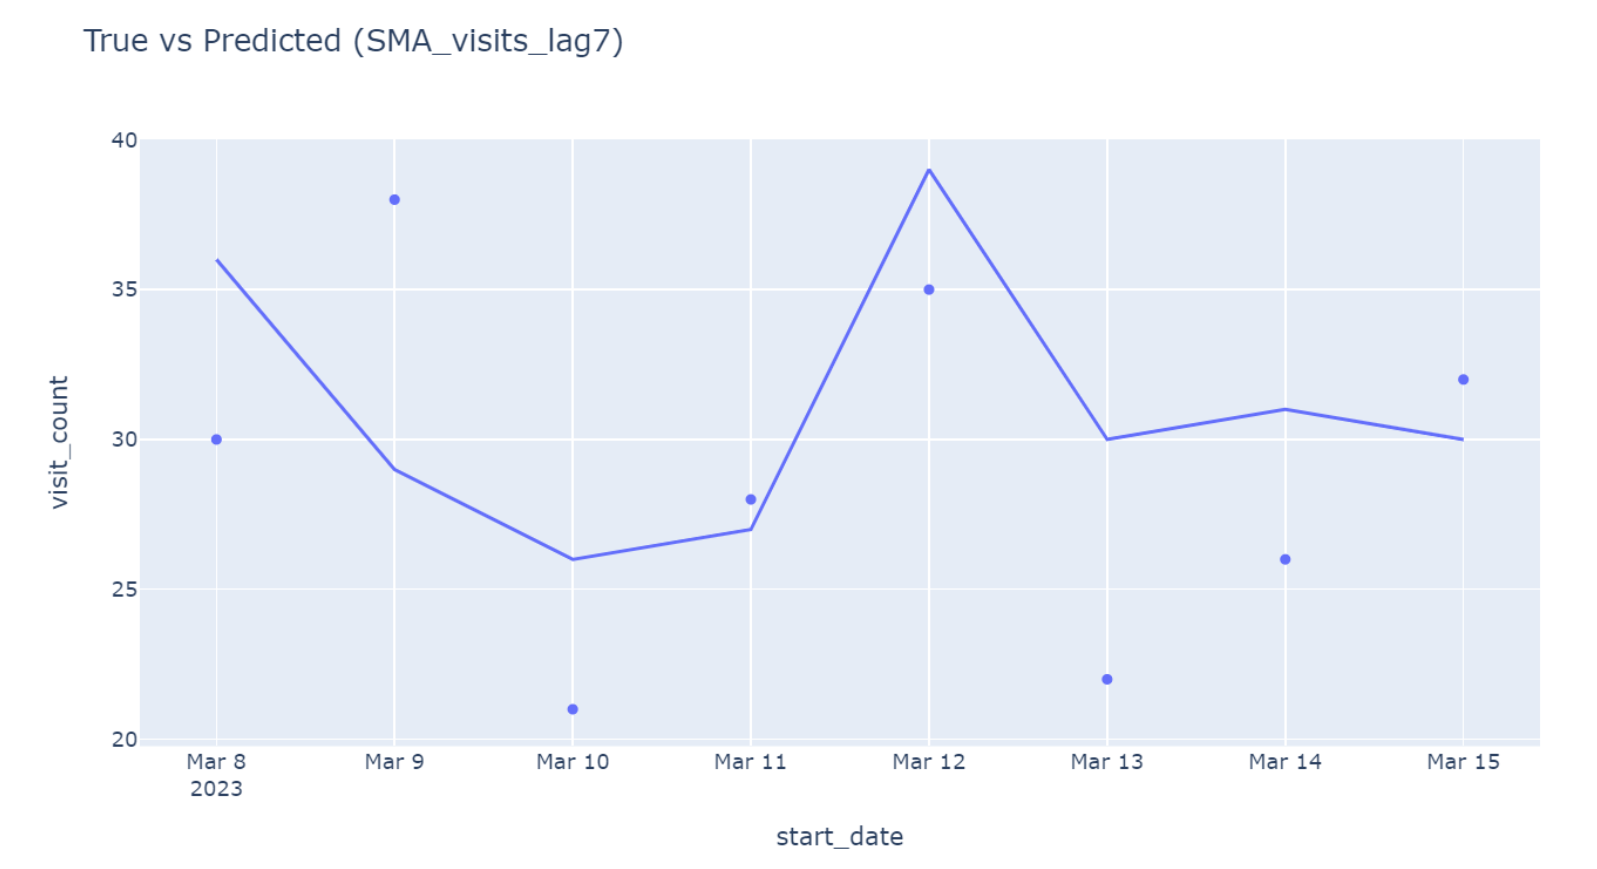

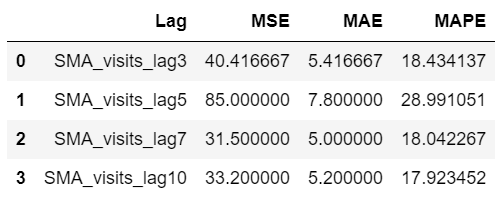

## Not SMA models: Prepros

In [17]:
df_model.columns

Index(['start_date', 'h3_9', 'visit_count', 'total_gender', 'avg_duration',
       'Stay0_05h', 'Stay05_1h', 'Stay1_3h', 'Stay3_6h', 'Stay6_9h',
       'Stay9_15h', 'Stay15_20h', 'Stay20_plus', 'morning_visits',
       'day_visits', 'evening_visits', 'night_visits', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'weekday',
       'weekend', 'amenity_count', 'building_count', 'footway_count',
       'highway_count', 'cafe_count', 'restaurant_count', 'fast_food_count',
       'retail_count', 'crossing_count', 'hospital_count', 'pharmacy_count',
       'bank_count', 'apartments_count', 'bus_stop_count', 'university_count',
       'dormitory_count', 'bench_count', 'school_count', 'atm_count',
       'theatre_count', 'language_school_count', 'commercial_count',
       'office_count', 'clinic_count', 'train_station_count', 'house_count',
       'townhall_count', 'hotel_count', 'college_count', 'terrace_count',
       'detached_count', 'age_20_share', 'ag

In [18]:
hex_1 = df_model[df_model.h3_9 == '891106004b7ffff'].drop(columns=['total_gender'])
hex_1.head(5)

,start_date,h3_9,visit_count,avg_duration,Stay0_05h,Stay05_1h,Stay1_3h,Stay3_6h,Stay6_9h,Stay9_15h,Stay15_20h,Stay20_plus,morning_visits,day_visits,evening_visits,night_visits,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,hospital_count,...,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,office_count,clinic_count,train_station_count,house_count,townhall_count,hotel_count,college_count,terrace_count,detached_count,age_20_share,age_20_30_share,age_30_40_share,age_40_60_share,age_60_share,male_share,female_share,salary_1_share,salary_2_share,salary_3_share,salary_4_share,salary_5_share,car_owners_share,public_trnsprt_user_share,healthy_food_inter_share,not_citizen_rf_share,carsharing_user_share
0,2023-03-01 00:00:00+00:00,891106004b7ffff,36,2.592222,0,0,29,5,1,0,1,0,5,16,5,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.057395,0.392936,0.377483,0.172185,0.52686,0.47314,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
1,2023-03-02 00:00:00+00:00,891106004b7ffff,29,2.258276,0,1,20,8,0,0,0,0,8,9,2,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.057395,0.392936,0.377483,0.172185,0.52686,0.47314,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
2,2023-03-03 00:00:00+00:00,891106004b7ffff,26,2.075385,0,0,22,4,0,0,0,0,8,8,3,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.057395,0.392936,0.377483,0.172185,0.52686,0.47314,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
3,2023-03-04 00:00:00+00:00,891106004b7ffff,27,2.572593,0,2,18,5,1,1,0,0,6,9,6,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,10,0,0,0,6,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.057395,0.392936,0.377483,0.172185,0.52686,0.47314,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413
4,2023-03-05 00:00:00+00:00,891106004b7ffff,39,2.106410,0,3,28,7,1,0,0,0,8,10,7,14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,10,0,0,0,6,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.057395,0.392936,0.377483,0.172185,0.52686,0.47314,0.389175,0.157216,0.262887,0.131443,0.059278,0.384298,0.041322,0.018595,0.469008,0.200413


In [19]:
def create_visit_count_columns(df, column_name, lag_days):
    for lag in range(1, lag_days + 1):
        lag_col = f'{column_name}_lag{lag}'
        df[lag_col] = df.groupby('h3_9')[column_name].shift(lag)
    return df


shifted_data = create_visit_count_columns(hex_1, 'visit_count', 7)

In [20]:
shifted_data = create_visit_count_columns(shifted_data, 'Stay0_05h', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'Stay05_1h', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'Stay1_3h', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'Stay3_6h', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'Stay6_9h', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'Stay9_15h', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'Stay15_20h', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'Stay20_plus', lag_days=3)

In [21]:
columns_to_drop = ['Stay0_05h', 'Stay05_1h', 'Stay1_3h', 'Stay3_6h', 'Stay6_9h',
                   'Stay9_15h', 'Stay15_20h', 'Stay20_plus']

shifted_data = shifted_data.drop(columns=columns_to_drop)

In [22]:
shifted_data = create_visit_count_columns(shifted_data, 'morning_visits', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'day_visits', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'evening_visits', lag_days=3)
shifted_data = create_visit_count_columns(shifted_data, 'night_visits', lag_days=3)

In [23]:
columns_to_drop = ['morning_visits', 'day_visits', 'evening_visits', 'night_visits']

shifted_data = shifted_data.drop(columns=columns_to_drop)

In [24]:
shifted_data 

,start_date,h3_9,visit_count,avg_duration,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,hospital_count,pharmacy_count,bank_count,apartments_count,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,...,Stay0_05h_lag2,Stay0_05h_lag3,Stay05_1h_lag1,Stay05_1h_lag2,Stay05_1h_lag3,Stay1_3h_lag1,Stay1_3h_lag2,Stay1_3h_lag3,Stay3_6h_lag1,Stay3_6h_lag2,Stay3_6h_lag3,Stay6_9h_lag1,Stay6_9h_lag2,Stay6_9h_lag3,Stay9_15h_lag1,Stay9_15h_lag2,Stay9_15h_lag3,Stay15_20h_lag1,Stay15_20h_lag2,Stay15_20h_lag3,Stay20_plus_lag1,Stay20_plus_lag2,Stay20_plus_lag3,morning_visits_lag1,morning_visits_lag2,morning_visits_lag3,day_visits_lag1,day_visits_lag2,day_visits_lag3,evening_visits_lag1,evening_visits_lag2,evening_visits_lag3,night_visits_lag1,night_visits_lag2,night_visits_lag3
0,2023-03-01 00:00:00+00:00,891106004b7ffff,36,2.592222,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-03-02 00:00:00+00:00,891106004b7ffff,29,2.258276,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,0.0,NaN,NaN,29.0,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,5.0,NaN,NaN,16.0,NaN,NaN,5.0,NaN,NaN,10.0,NaN,NaN
2,2023-03-03 00:00:00+00:00,891106004b7ffff,26,2.075385,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,NaN,1.0,0.0,NaN,20.0,29.0,NaN,8.0,5.0,NaN,0.0,1.0,NaN,0.0,0.0,NaN,0.0,1.0,NaN,0.0,0.0,NaN,8.0,5.0,NaN,9.0,16.0,NaN,2.0,5.0,NaN,10.0,10.0,NaN
3,2023-03-04 00:00:00+00:00,891106004b7ffff,27,2.572593,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,22.0,20.0,29.0,4.0,8.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,8.0,5.0,8.0,9.0,16.0,3.0,2.0,5.0,7.0,10.0,10.0
4,2023-03-05 00:00:00+00:00,891106004b7ffff,39,2.106410,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,2.0,0.0,1.0,18.0,22.0,20.0,5.0,4.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0,8.0,9.0,8.0,9.0,6.0,3.0,2.0,6.0,7.0,10.0
5,2023-03-06 00:00:00+00:00,891106004b7ffff,30,2.501333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,3.0,2.0,0.0,28.0,18.0,22.0,7.0,5.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,8.0,10.0,9.0,8.0,7.0,6.0,3.0,14.0,6.0,7.0
6,2023-03-07 00:00:00+00:00,891106004b7ffff,31,2.900645,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,3.0,2.0,25.0,28.0,18.0,4.0,7.0,5.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,6.0,7.0,10.0,9.0,3.0,7.0,6.0,13.0,14.0,6.0
7,2023-03-08 00:00:00+00:00,891106004b7ffff,30,2.395333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,2.0,0.0,3.0,24.0,25.0,28.0,3.0,4.0,7.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,7.0,8.0,18.0,7.0,10.0,4.0,3.0,7.0,4.0,13.0,14.0
8,2023-03-09 00:00:00+00:00,891106004b7ffff,38,2.830000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,2.0,0.0,24.0,24.0,25.0,4.0,3.0,4.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,5.0,7.0,18.0,18.0,7.0,3.0,4.0,3.0,5.0,4.0,13.0
9,2023-03-10 00:00:00+00:00,891106004b7ffff,21,4.298095,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,3.0,0.0,2.0,27.0,24.0,24.0,2.0,4.0,3.0,5.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,4.0,5.0,9.0,18.0,18.0,5.0,3.0,4.0,13.0,5.0,4.0


## Model

In [30]:
shifted_data['start_date'] = pd.to_datetime(shifted_data['start_date']).dt.tz_localize(None)
train = (shifted_data.start_date > pd.to_datetime('2023-03-08')) & (shifted_data.start_date < pd.to_datetime('2023-03-15'))

In [31]:
shifted_data['start_date'] = pd.to_datetime(shifted_data['start_date']).dt.tz_localize(None)
test = shifted_data.start_date >= pd.to_datetime('2023-03-15')

In [32]:
X_train = shifted_data.loc[train, shifted_data.columns != 'visit_count']
X_test = shifted_data.loc[test, shifted_data.columns != 'visit_count']

y_train, y_test = shifted_data.loc[train, 'visit_count'],\
                  shifted_data.loc[test, 'visit_count']

In [33]:
X_train = X_train.drop(['start_date', 'h3_9'], axis=1)
X_test = X_test.drop(['start_date', 'h3_9'], axis=1)

In [34]:
X_train

,avg_duration,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,hospital_count,pharmacy_count,bank_count,apartments_count,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,office_count,clinic_count,train_station_count,...,Stay0_05h_lag2,Stay0_05h_lag3,Stay05_1h_lag1,Stay05_1h_lag2,Stay05_1h_lag3,Stay1_3h_lag1,Stay1_3h_lag2,Stay1_3h_lag3,Stay3_6h_lag1,Stay3_6h_lag2,Stay3_6h_lag3,Stay6_9h_lag1,Stay6_9h_lag2,Stay6_9h_lag3,Stay9_15h_lag1,Stay9_15h_lag2,Stay9_15h_lag3,Stay15_20h_lag1,Stay15_20h_lag2,Stay15_20h_lag3,Stay20_plus_lag1,Stay20_plus_lag2,Stay20_plus_lag3,morning_visits_lag1,morning_visits_lag2,morning_visits_lag3,day_visits_lag1,day_visits_lag2,day_visits_lag3,evening_visits_lag1,evening_visits_lag2,evening_visits_lag3,night_visits_lag1,night_visits_lag2,night_visits_lag3
8,2.830000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,2.0,0.0,24.0,24.0,25.0,4.0,3.0,4.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,5.0,7.0,18.0,18.0,7.0,3.0,4.0,3.0,5.0,4.0,13.0
9,4.298095,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,3.0,0.0,2.0,27.0,24.0,24.0,2.0,4.0,3.0,5.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,4.0,5.0,9.0,18.0,18.0,5.0,3.0,4.0,13.0,5.0,4.0
10,2.932857,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,3.0,0.0,10.0,27.0,24.0,7.0,2.0,4.0,2.0,5.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,11.0,4.0,7.0,9.0,18.0,2.0,5.0,3.0,9.0,13.0,5.0
11,2.233429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,3.0,1.0,3.0,18.0,10.0,27.0,4.0,7.0,2.0,2.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,3.0,11.0,14.0,7.0,9.0,2.0,2.0,5.0,7.0,9.0,13.0
12,2.404545,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,3.0,1.0,27.0,18.0,10.0,6.0,4.0,7.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,3.0,14.0,14.0,7.0,9.0,2.0,2.0,10.0,7.0,9.0
13,2.236538,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,3.0,18.0,27.0,18.0,2.0,6.0,4.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,3.0,14.0,14.0,6.0,9.0,2.0,12.0,10.0,7.0


In [35]:
X_test

,avg_duration,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,weekday,weekend,amenity_count,building_count,footway_count,highway_count,cafe_count,restaurant_count,fast_food_count,retail_count,crossing_count,hospital_count,pharmacy_count,bank_count,apartments_count,bus_stop_count,university_count,dormitory_count,bench_count,school_count,atm_count,theatre_count,language_school_count,commercial_count,office_count,clinic_count,train_station_count,...,Stay0_05h_lag2,Stay0_05h_lag3,Stay05_1h_lag1,Stay05_1h_lag2,Stay05_1h_lag3,Stay1_3h_lag1,Stay1_3h_lag2,Stay1_3h_lag3,Stay3_6h_lag1,Stay3_6h_lag2,Stay3_6h_lag3,Stay6_9h_lag1,Stay6_9h_lag2,Stay6_9h_lag3,Stay9_15h_lag1,Stay9_15h_lag2,Stay9_15h_lag3,Stay15_20h_lag1,Stay15_20h_lag2,Stay15_20h_lag3,Stay20_plus_lag1,Stay20_plus_lag2,Stay20_plus_lag3,morning_visits_lag1,morning_visits_lag2,morning_visits_lag3,day_visits_lag1,day_visits_lag2,day_visits_lag3,evening_visits_lag1,evening_visits_lag2,evening_visits_lag3,night_visits_lag1,night_visits_lag2,night_visits_lag3
14,2.39,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10,0,0,0,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,1.0,19.0,18.0,27.0,6.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,2.0,7.0,3.0,14.0,4.0,6.0,9.0,10.0,12.0,10.0


In [36]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

## With StandardScaler

In [40]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

models = {
    'RandomForestRegressor': RandomForestRegressor(max_depth=70, min_samples_leaf=2, min_samples_split=6, n_estimators=50),
    'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=50),
    'LinearRegression': LinearRegression(),
}

results = {'Lag': [], 'MSE_train': [], 'MAE_train': [], 'MAPE_train': [], 'MSE_test': [], 'MAE_test': [], 'MAPE_test': []}
for model_name, model in models.items():
    model.fit(X_train_std, y_train)
    
    pred_train = model.predict(X_train_std)
    pred_test = model.predict(X_test_std)
    
    mse_train = mean_squared_error(y_train, pred_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    mape_train = np.mean(np.abs((y_train - pred_train) / y_train)) * 100

    mse_test = mean_squared_error(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mape_test = np.mean(np.abs((y_test - pred_test) / y_test)) * 100

    results['Lag'].append(model_name)
    results['MSE_train'].append(mse_train)
    results['MAE_train'].append(mae_train)
    results['MAPE_train'].append(mape_train)
    results['MSE_test'].append(mse_test)
    results['MAE_test'].append(mae_test)
    results['MAPE_test'].append(mape_test)

df_metrics_train = pd.DataFrame({
    'MODEL': results['Lag'],
    'MSE': results['MSE_train'],
    'MAE': results['MAE_train'],
    'MAPE': results['MAPE_train']
})

df_metrics_test = pd.DataFrame({
    'MODEL': results['Lag'],
    'MSE': results['MSE_test'],
    'MAE': results['MAE_test'],
    'MAPE': results['MAPE_test']
})

print("Metrics for Training Set:")
print(df_metrics_train)

print("\nMetrics for Test Set:")
print(df_metrics_test)

Metrics for Training Set:
                       MODEL           MSE           MAE          MAPE
0      RandomForestRegressor  3.977333e+01  5.600000e+00  2.060052e+01
1  GradientBoostingRegressor  1.521824e+01  3.358364e+00  1.216779e+01
2           LinearRegression  2.734718e-29  4.144833e-15  1.752893e-14

Metrics for Test Set:
                       MODEL        MSE       MAE       MAPE
0      RandomForestRegressor  10.240000  3.200000  10.000000
1  GradientBoostingRegressor  15.018286  3.875343  12.110448
2           LinearRegression   7.064834  2.657976   8.306174


In [41]:
df_metrics_train

,MODEL,MSE,MAE,MAPE
0,RandomForestRegressor,3.977333e+01,5.600000e+00,2.060052e+01
1,GradientBoostingRegressor,1.521824e+01,3.358364e+00,1.216779e+01
2,LinearRegression,2.734718e-29,4.144833e-15,1.752893e-14


In [42]:
df_metrics_test

,MODEL,MSE,MAE,MAPE
0,RandomForestRegressor,10.240000,3.200000,10.000000
1,GradientBoostingRegressor,15.018286,3.875343,12.110448
2,LinearRegression,7.064834,2.657976,8.306174


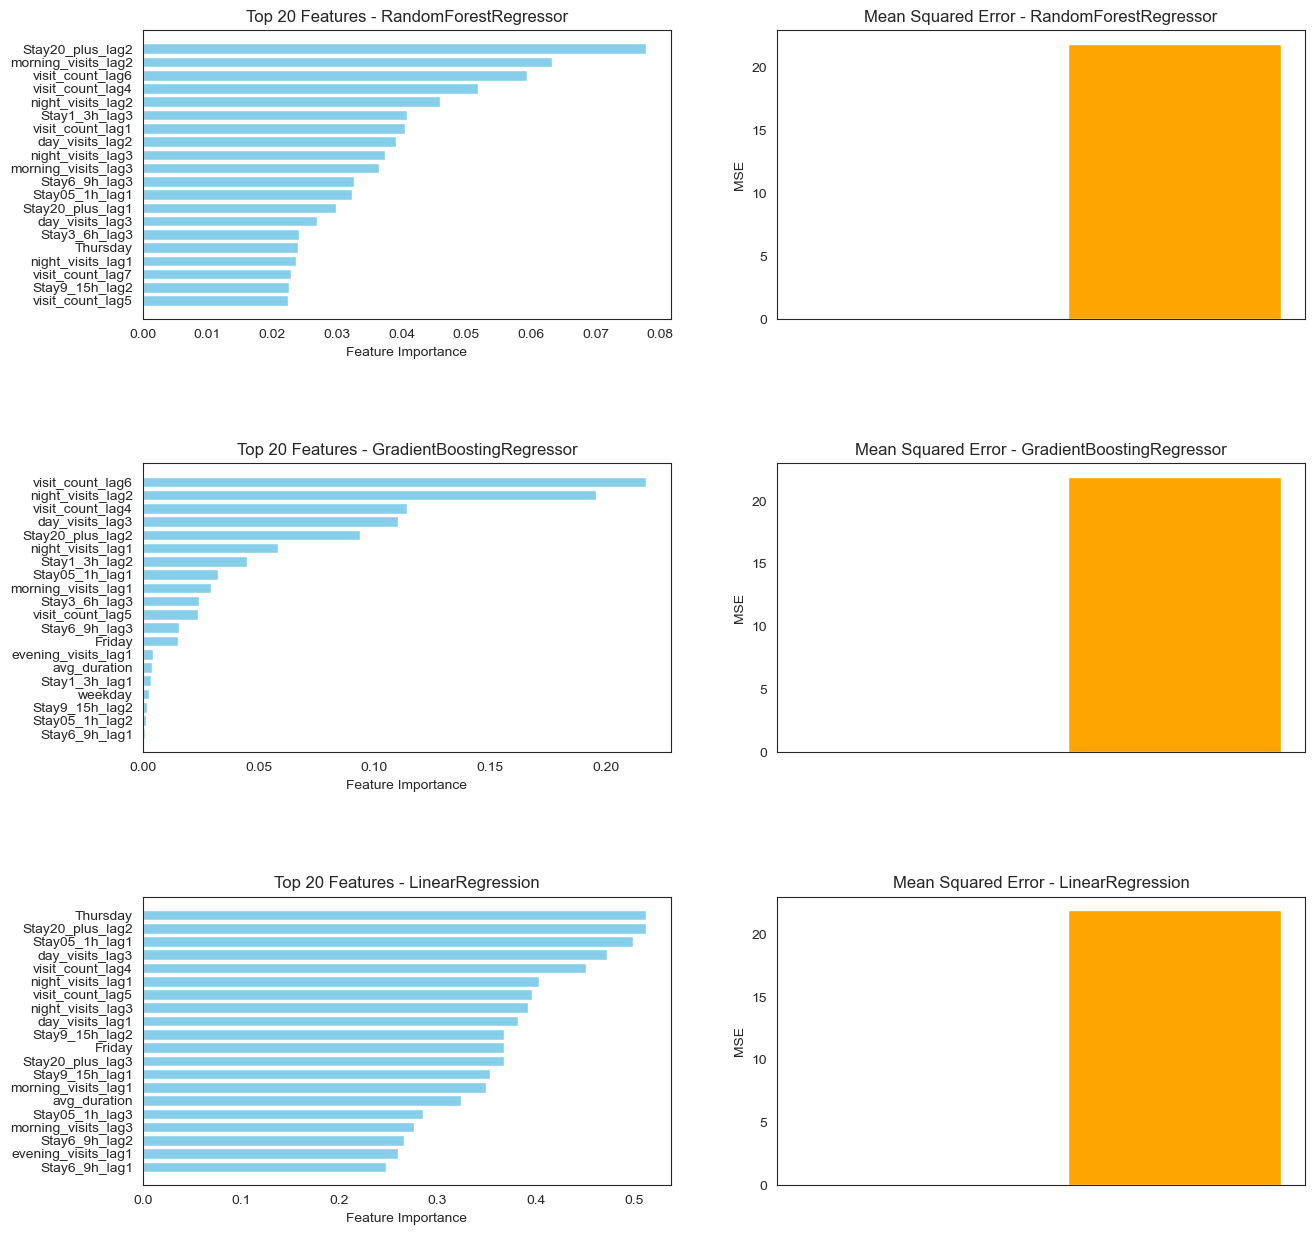

In [71]:
def get_feature_importances(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        return model.feature_importances_
    elif hasattr(model, 'coef_'):
        return np.abs(model.coef_)
    else:
        return None

plt.subplots_adjust(hspace=0.5)

for i, (model_name, model) in enumerate(models.items()):
    feature_importances = get_feature_importances(model, X_train.columns)

    top_features_idx = np.argsort(feature_importances)[-20:][::-1]
    top_features = X_train.columns[top_features_dx]
    top_feature_importances = feature_importances[top_features_idx]


    axes[i, 0].barh(top_features[::-1], top_feature_importances[::-1], color='skyblue')
    axes[i, 0].set_title(f'Top 20 Features - {model_name}')
    axes[i, 0].set_xlabel('Feature Importance')

    axes[i, 1].bar([f'Training Set ({model_name})', 'Test Set'], [mse_train, mse_test], color=['skyblue', 'orange'])
    axes[i, 1].set_title(f'Mean Squared Error - {model_name}')
    axes[i, 1].set_ylabel('MSE')
    axes[i, 1].set_xticklabels([])

plt.show()

## Grid Search

**RandomForestRegressor**

In [78]:
%%time
rf_param_grid = {
    'n_estimators': [50, 100, 150, 250],
    'max_depth': [None, 5, 10, 20, 30, 50],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor()
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, scoring='neg_mean_squared_error', cv=3)
rf_grid_search.fit(X_train_std, y_train)

best_params_rf = rf_grid_search.best_params_
print("Best Hyperparameters for RandomForestRegressor:", best_params_rf)

rf_best_model = rf_grid_search.best_estimator_
rf_pred_test = rf_best_model.predict(X_test_std)
mse_test_rf = mean_squared_error(y_test, rf_pred_test)
print("MSE on Test Set for RandomForestRegressor:", mse_test_rf)

Best Hyperparameters for RandomForestRegressor: {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 50}
MSE on Test Set for RandomForestRegressor: 26.697524999999995
CPU times: total: 2min 36s
Wall time: 2min 38s


In [79]:
%%time
gb_param_grid = {
    'n_estimators': [50, 100, 150, 250],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

gb_model = GradientBoostingRegressor()
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, scoring='neg_mean_squared_error', cv=3)
gb_grid_search.fit(X_train_std, y_train)

best_params_gb = gb_grid_search.best_params_
print("Best Hyperparameters for GradientBoostingRegressor:", best_params_gb)

gb_best_model = gb_grid_search.best_estimator_
gb_pred_test = gb_best_model.predict(X_test_std)
mse_test_gb = mean_squared_error(y_test, gb_pred_test)
print("MSE on Test Set for GradientBoostingRegressor:", mse_test_gb)

Best Hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
MSE on Test Set for GradientBoostingRegressor: 27.99857037582446
CPU times: total: 1min 44s
Wall time: 1min 45s


## PCA

**X_train**

In [43]:
df_for_pca = X_train

In [44]:
scaler = StandardScaler()
scaler.fit(df_for_pca)
scaled_df_nost = pd.DataFrame(scaler.transform(df_for_pca),columns= df_for_pca.columns )

pca = PCA(n_components=None, random_state = 15).fit(scaled_df_nost)


varExplainedRatio = pca.explained_variance_ratio_
print(varExplainedRatio)
print()
cumulVarExplained = np.cumsum(varExplainedRatio)
cumulVarExplained

[2.72438381e-01 2.49642874e-01 2.13060441e-01 1.60373303e-01
 1.04485000e-01 4.41008490e-33]



array([0.27243838, 0.52208126, 0.7351417 , 0.895515  , 1.        ,
       1.        ])

In [45]:
def varplot(x, label, h=0):
    plt.plot(range(len(x)), x, linestyle="-.")
    plt.title('Plot of '+ label + ' variance')
    plt.xticks(range(len(x)), [y+1 for y in range(len(x))])
    plt.xlabel('Principal components')
    plt.axhline(h)
    plt.grid()
    plt.show()

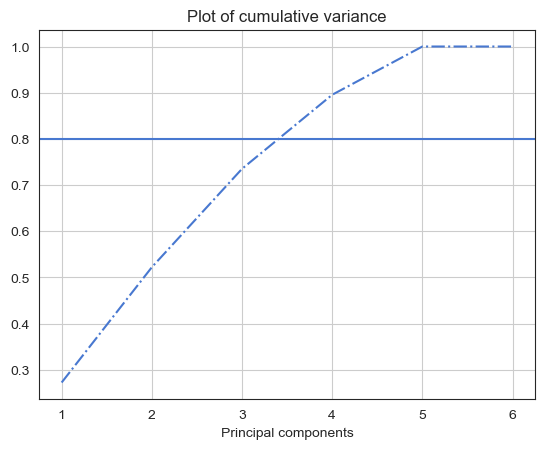

In [46]:
varplot(cumulVarExplained, "cumulative", h=0.8)

**X_test**

In [63]:
df_for_pca = X_train

In [65]:
scaler = StandardScaler()
scaler.fit(df_for_pca)
scaled_df_nost = pd.DataFrame(scaler.transform(df_for_pca),columns= df_for_pca.columns )

pca = PCA(n_components=None, random_state = 15).fit(scaled_df_nost)


varExplainedRatio = pca.explained_variance_ratio_
print(varExplainedRatio)
print()
cumulVarExplained = np.cumsum(varExplainedRatio)
cumulVarExplained

[2.72438381e-01 2.49642874e-01 2.13060441e-01 1.60373303e-01
 1.04485000e-01 4.41008490e-33]



array([0.27243838, 0.52208126, 0.7351417 , 0.895515  , 1.        ,
       1.        ])

In [66]:
def varplot(x, label, h=0):
    plt.plot(range(len(x)), x, linestyle="-.")
    plt.title('Plot of '+ label + ' variance')
    plt.xticks(range(len(x)), [y+1 for y in range(len(x))])
    plt.xlabel('Principal components')
    plt.axhline(h)
    plt.grid()
    plt.show()

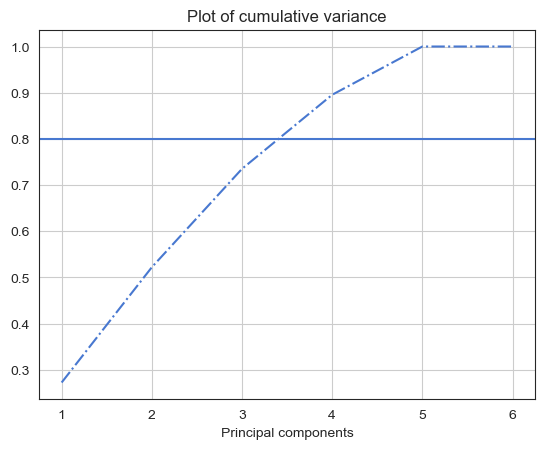

In [67]:
varplot(cumulVarExplained, "cumulative", h=0.8)

## Model with PCA

In [68]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'LinearRegression': LinearRegression(),
}

results = {'Lag': [], 'MSE_train': [], 'MAE_train': [], 'MAPE_train': [], 'MSE_test': [], 'MAE_test': [], 'MAPE_test': []}
for model_name, model in models.items():
    model.fit(X_train_pca, y_train)
    
    # Predictions
    pred_train = model.predict(X_train_pca)
    pred_test = model.predict(X_test_pca)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, pred_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    mape_train = np.mean(np.abs((y_train - pred_train) / y_train)) * 100

    mse_test = mean_squared_error(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mape_test = np.mean(np.abs((y_test - pred_test) / y_test)) * 100

    # Append results to the dictionary
    results['Lag'].append(model_name)
    results['MSE_train'].append(mse_train)
    results['MAE_train'].append(mae_train)
    results['MAPE_train'].append(mape_train)
    results['MSE_test'].append(mse_test)
    results['MAE_test'].append(mae_test)
    results['MAPE_test'].append(mape_test)

# Create DataFrames
df_metrics_train = pd.DataFrame({
    'MODEL': results['Lag'],
    'MSE': results['MSE_train'],
    'MAE': results['MAE_train'],
    'MAPE': results['MAPE_train']
})

df_metrics_test = pd.DataFrame({
    'MODEL': results['Lag'],
    'MSE': results['MSE_test'],
    'MAE': results['MAE_test'],
    'MAPE': results['MAPE_test']
})

# Display DataFrames
print("Metrics for Training Set:")
print(df_metrics_train)

print("\nMetrics for Test Set:")
print(df_metrics_test)

Metrics for Training Set:
                       MODEL           MSE       MAE       MAPE
0      RandomForestRegressor  6.120017e+00  2.028333   7.356715
1  GradientBoostingRegressor  2.790676e-08  0.000145   0.000524
2           LinearRegression  1.977774e+01  3.496708  11.992432

Metrics for Test Set:
                       MODEL        MSE       MAE       MAPE
0      RandomForestRegressor   2.992900  1.730000   5.406250
1  GradientBoostingRegressor  35.996919  5.999743  18.749198
2           LinearRegression   2.074003  1.440140   4.500437


In [69]:
df_metrics_test

,MODEL,MSE,MAE,MAPE
0,RandomForestRegressor,2.992900,1.730000,5.406250
1,GradientBoostingRegressor,35.996919,5.999743,18.749198
2,LinearRegression,2.074003,1.440140,4.500437
